In [1]:
import scanpy as sc
#from cellbender.remove_background.downstream import anndata_from_h5
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1966)

def sanitize_types_for_h5(adata):
    adata.var=adata.var.convert_dtypes()
    adata.obs=adata.obs.convert_dtypes()

    for c,t in zip(adata.obs.columns,adata.obs.dtypes):
        adata.obs[c]=adata.obs[c].to_list()
        if t == object:
            print(c,t)
            adata.obs[c]=pd.to_numeric(adata.obs[c], errors='coerce')

    for c,t in zip(adata.var.columns,adata.var.dtypes):
        adata.var[c]=adata.var[c].to_list()
        if t == object:
            print(c,t)
            adata.var[c]=pd.to_numeric(adata.var[c], errors='coerce')
    
    if adata.raw is not None:
        adata.raw.var.columns = adata.raw.var.columns.astype(str)
        for c,t in zip(adata.raw.var.columns,adata.raw.var.dtypes):
            adata.raw.var[c]=adata.raw.var[c].to_list()
            if t == object:
                adata.var[c]=pd.to_numeric(adata.raw.var[c], errors='coerce')
    
    adata.obs=adata.obs.fillna(np.nan)
    adata.var=adata.var.fillna(np.nan)
    adata.var.columns = adata.var.columns.astype(str)
    adata.obs.columns = adata.obs.columns.astype(str)
    return(adata)

def ismember(a, b):
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    result = [bind.get(itm, None) for itm in a]  # None can be replaced by any other "not in b" value
    result = [result, [not x is None for x in result]]
    return result

def norm_log_transform(adata_local, size_factors, cell_filter):
    if(len(cell_filter) > 0):
        adata_local = adata_local[cell_filter,:].copy()
        size_factors = np.array(size_factors)[cell_filter]
    else:
        adata_local = adata_local.copy()
    print("Normalizing data")
    if(scipy.sparse.issparse(adata_local.X)):
        c = scipy.sparse.diags(1/size_factors)
        adata_local.X = c * adata_local.X * np.median(size_factors)
    else:
        adata_local.X = adata_local.X / size_factors[:,None] * np.median(size_factors)
    
    print("Log transform with pseudocount 1")
    sc.pp.log1p(adata_local)
    return(adata_local)


In [2]:
from cellbender.remove_background.downstream import load_anndata_from_input_and_output


In [3]:
import cellbender
print(cellbender.__version__)

0.3.0


In [5]:
import scanpy 
print(scanpy.__version__)

1.10.0


In [2]:
#adata = sc.read_10x_h5('temporal_directory/immune/outs/raw_feature_bc_matrix.h5')
#adata_filtered = sc.read_10x_h5('temporal_directory/immune/outs/filtered_feature_bc_matrix.h5')
#adata_bender = sc.read_10x_h5('temporal_directory/cellbender_output/immune/output.h5', )


In [30]:
from cellbender.remove_background.downstream import load_anndata_from_input_and_output

#adata = load_anndata_from_input_and_output(
#    input_file='temporal_directory/immune/outs/raw_feature_bc_matrix.h5',
#    output_file='temporal_directory/cellbender_output/immune/output.h5',
#    input_layer_key='raw',  # this will be the raw data layer
#)

adata = load_anndata_from_input_and_output(
    input_file='../cellranger_output/keratinocytes/outs/raw_feature_bc_matrix.h5',
    output_file='../cellbender_output/keratinocytes/output.h5',
    input_layer_key='raw',  # this will be the raw data layer
)

adata = adata[adata.obs['cell_probability'] > 0.5]
adata.var_names_make_unique()
adata

/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 10896 × 32293
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'

In [31]:
adata

AnnData object with n_obs × n_vars = 10896 × 32293
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_rate'
    obsm: 'cellbender_embedding'
    layers: 'raw', 'cellbender'

In [32]:
adata.var_names = [x.upper() for x in adata.var_names]
ribo_genes = ismember(adata.var_names, pd.read_csv('../ribosomal_genes.092820.csv')['ribosomal_genes'])[1]
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.array(np.sum(adata.X[:, mito_genes], axis=1) / np.sum(adata.X, axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata.X[:, ribo_genes], axis=1) / np.sum(adata.X, axis=1))
excluded_genes = [x or y for x,y in zip(ribo_genes, mito_genes)]
adata.var['excluded'] = excluded_genes

In [33]:
meta_info = adata[:, ['D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2']]
all_genes = adata.var_names
no_barcodes = [i for i in all_genes if i not in ['D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2']]
adata = adata[:, no_barcodes]

In [34]:
adata.obs['log_lib_size_raw_all'] = np.log(np.ravel(np.array(adata.layers['raw'].sum(axis = 1) + 1)))
adata.obs['log_lib_size_raw_noExcluded'] = np.log(np.ravel(np.array(adata.layers['raw'][:,np.logical_not(adata.var['excluded'])].sum(axis = 1) + 1)))
adata.obs['log_detected_raw_all'] = np.log(np.ravel(np.array((adata.layers['raw'] > 0).sum(axis = 1) + 1)))
adata.obs['log_detected_raw_noExcluded'] = np.log(np.ravel(np.array(adata.layers['raw'][:,np.logical_not(adata.var['excluded'] > 0)].sum(axis = 1) + 1)))

adata.obs['log_lib_size_cellbender_all'] = np.log(np.ravel(np.array(adata.layers['cellbender'].sum(axis = 1) + 1)))
adata.obs['log_lib_size_cellbender_noExcluded'] = np.log(np.ravel(np.array(adata.layers['cellbender'][:,np.logical_not(adata.var['excluded'])].sum(axis = 1) + 1)))
adata.obs['log_detected_cellbender_all'] = np.log(np.ravel(np.array((adata.layers['cellbender'] > 0).sum(axis = 1) + 1)))
adata.obs['log_detected_cellbender_noExcluded'] = np.log(np.ravel(np.array(adata.layers['cellbender'][:,np.logical_not(adata.var['excluded'] > 0)].sum(axis = 1) + 1)))



/tmp/ipykernel_4059/387225759.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['log_lib_size_raw_all'] = np.log(np.ravel(np.array(adata.layers['raw'].sum(axis = 1) + 1)))


In [35]:
adata

AnnData object with n_obs × n_vars = 10896 × 32285
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_scale', 'swapping_fraction_dist_params', 'estimator', 'features_analyzed_inds', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_learning_rate_value', 'learning_curve_test_elbo', 'learning_curve_test_epoch', 'learning_curve_train_elbo', 'learning_curve_train_epoch', 'target_false_positive_

# Filter low quality and empty droplets

In [36]:
adata_sub = adata.copy()
layer = 'cellbender'
size_factors = 'log_lib_size_cellbender_all' 
adata_sub.X = adata_sub.layers['cellbender'].copy()
adata_sub = norm_log_transform(adata_sub, np.exp(adata_sub.obs[size_factors]), [])
sc.pp.filter_cells(adata_sub, min_counts = 1)
sc.pp.filter_genes(adata_sub, min_cells = 10)
#adata_sub = lowess_HVG(adata_sub, n_bin=200, n_genes_per_bin=20, min_mean=0.001, exclude_genes=adata_sub.var['excluded'], plot_show=True)
sc.pp.highly_variable_genes(adata_sub, n_top_genes = 5000)
sc.pp.pca(adata_sub, n_comps = 100, use_highly_variable = True)
sc.pp.neighbors(adata_sub, n_neighbors = 31)
sc.tl.umap(adata_sub)

Normalizing data


/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/scipy/sparse/_construct.py:148: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(diagonals) == 0 or isscalarlike(diagonals[0]):


Log transform with pseudocount 1


/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [37]:
print(np.sum(adata_sub.var['highly_variable']))
communities = sc.external.tl.phenograph(adata_sub, k = 30, clustering_algo = 'leiden', seed = 0, copy = True)
adata_sub.obs['pheno'] = pd.Categorical(communities[0])

5000
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2380361557006836 seconds
Jaccard graph constructed in 1.7444939613342285 seconds
Running Leiden optimization
Leiden completed in 2.842491626739502 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 5.609845876693726 seconds


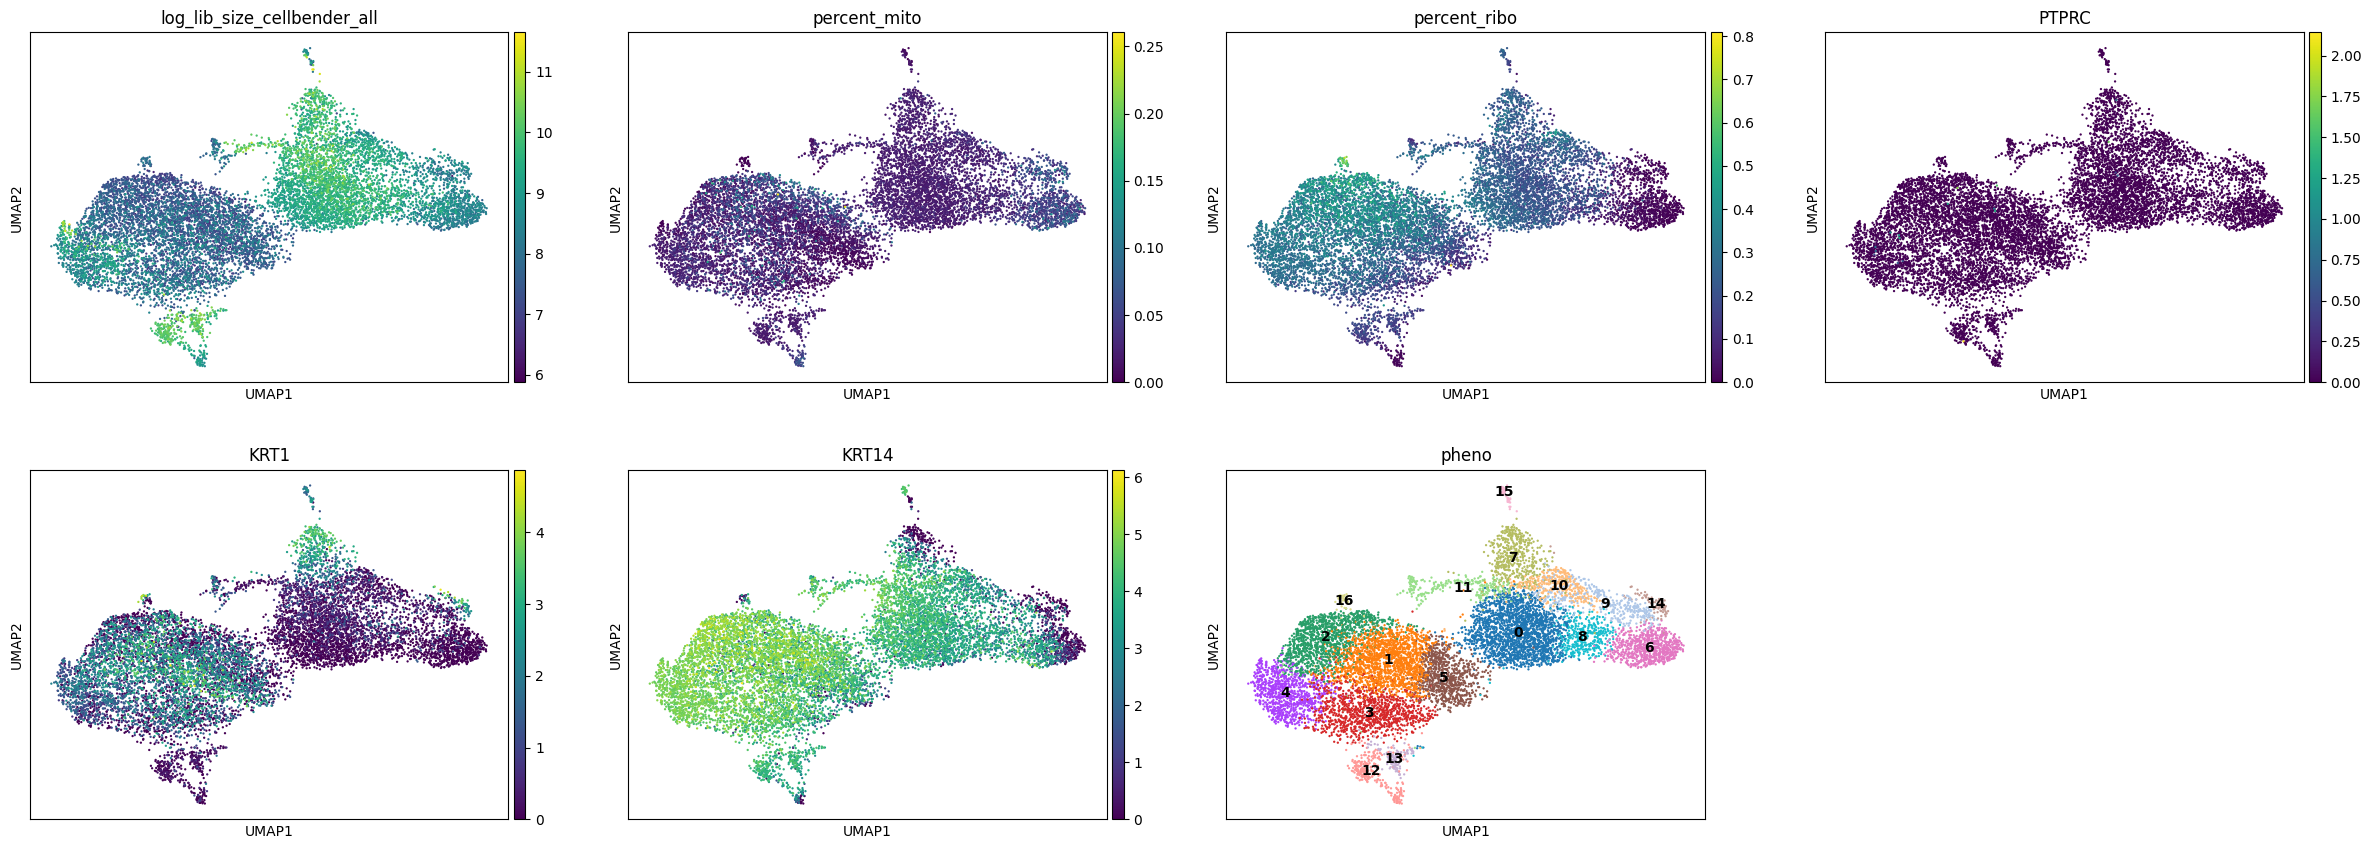

In [38]:
sc.pl.umap(adata_sub, color=['log_lib_size_cellbender_all', 'percent_mito', 'percent_ribo', 'PTPRC', 'KRT1', 'KRT14', 'pheno'], legend_loc  =  'on data', frameon  = True) 

In [39]:
sc.pp.calculate_qc_metrics(adata_sub, percent_top=None, log1p=False, inplace=True)

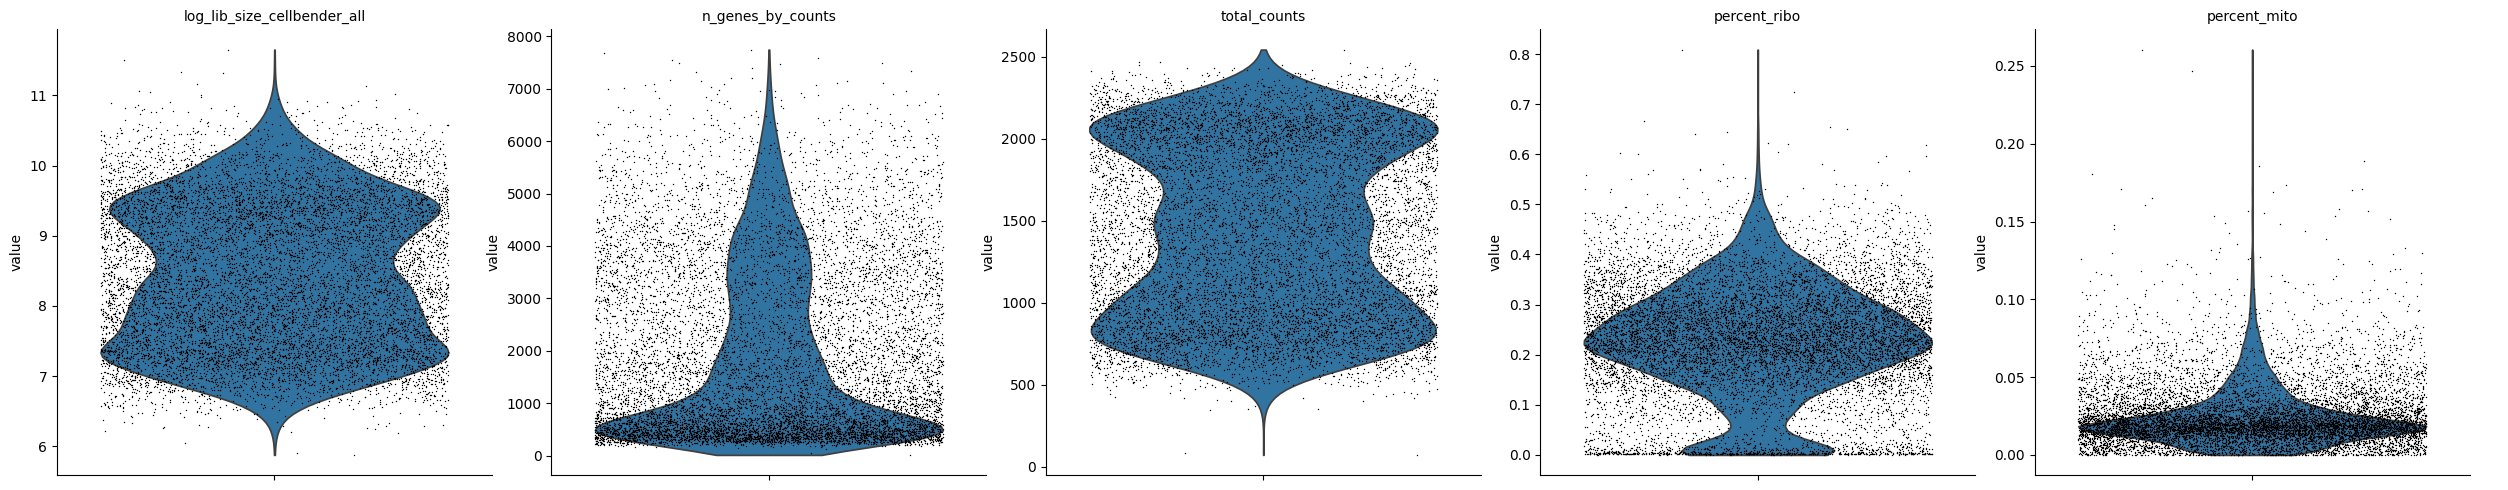

In [40]:
sc.pl.violin(adata_sub, ['log_lib_size_cellbender_all',  'n_genes_by_counts', 'total_counts', 'percent_ribo', 'percent_mito'],
             jitter=0.4, multi_panel=True)

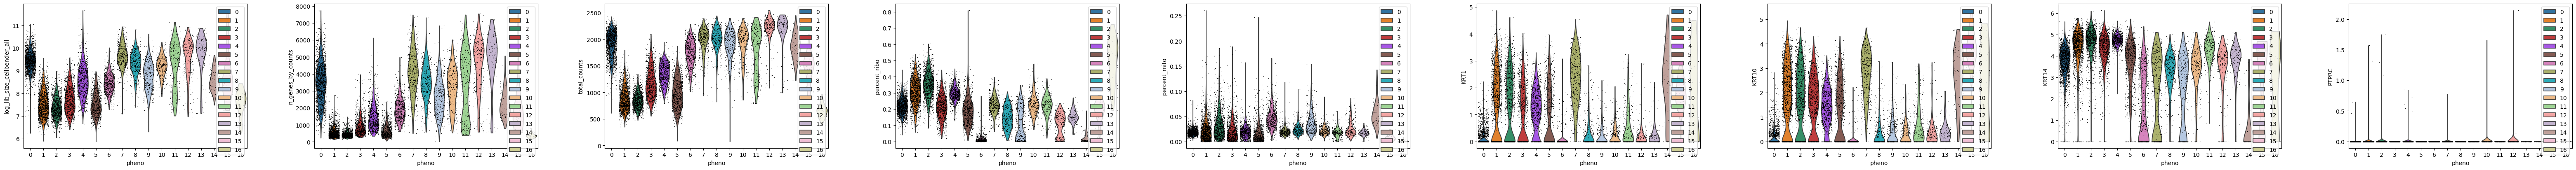

In [41]:
sc.pl.violin(adata_sub, ['log_lib_size_cellbender_all',  'n_genes_by_counts', 'total_counts', 'percent_ribo', 'percent_mito', 'KRT1', 'KRT10', 'KRT14', 'PTPRC'], groupby = 'pheno', jitter=0.4, multi_panel=True)

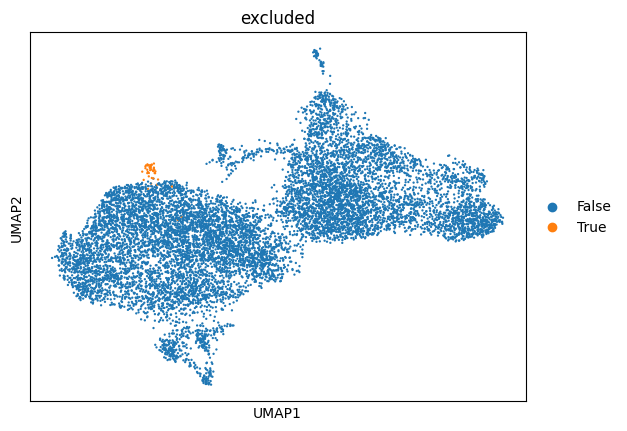

In [42]:
###
## Cluster 16 based on high ribosomal level
adata_sub.obs['excluded'] = pd.Categorical(ismember(adata_sub.obs['pheno'], [16])[1])
sc.pl.umap(adata_sub, color='excluded')
#display((adata_sub.obs['excluded'] == False).groupby(adata_sub.obs['replicate_id']).agg('sum'))

In [43]:
meta_info = meta_info[adata_sub.obs['excluded'] == False,:].copy()
adata_sub = adata_sub[adata_sub.obs['excluded'] == False,:].copy()


In [44]:
adata_sub.obs['D30_CTRL_1'] = meta_info.to_df()['D30_CTRL_1'].to_list()
adata_sub.obs['D30_CTRL_2'] = meta_info.to_df()['D30_CTRL_2'].to_list()
adata_sub.obs['D30_PIMQ_1'] = meta_info.to_df()['D30_PIMQ_1'].to_list()
adata_sub.obs['D30_PIMQ_2'] = meta_info.to_df()['D30_PIMQ_2'].to_list()
adata_sub.obs['Y1_CTRL_1'] = meta_info.to_df()['Y1_CTRL_1'].to_list()
adata_sub.obs['Y1_CTRL_2'] = meta_info.to_df()['Y1_CTRL_2'].to_list()
adata_sub.obs['Y1_PIMQ_1'] = meta_info.to_df()['Y1_PIMQ_1'].to_list()
adata_sub.obs['Y1_PIMQ_2'] = meta_info.to_df()['Y1_PIMQ_2'].to_list()


# Filter Outlier based on low library size (log_Detected_counts < 6, mito > 0.3)

/tmp/ipykernel_4059/1264330931.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [10]
/tmp/ipykernel_4059/1264330931.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [20]


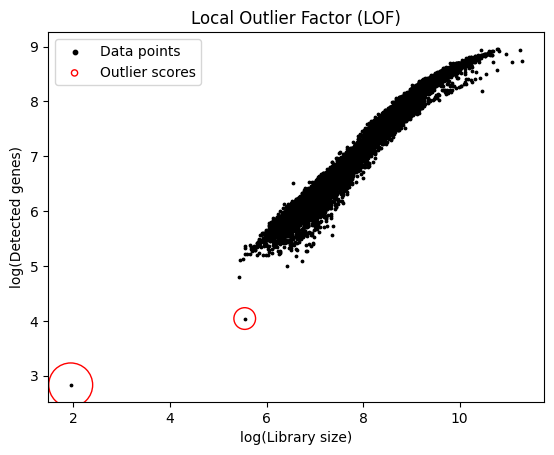

In [45]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=100, contamination=0.1)
X = np.array([[x,y] for x,y in zip(adata_sub.obs['log_lib_size_cellbender_noExcluded'], adata_sub.obs['log_detected_cellbender_all'])])
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")

# plot circles with radius proportional to the outlier scores

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

radius_threshold = 0.2

radius_filter = np.logical_and(radius > radius_threshold, adata_sub.obs['log_detected_cellbender_all'] < 7)

plt.scatter(
    X[radius_filter, 0],
    X[radius_filter, 1],
    s=1000 * radius[radius_filter],
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
#plt.scatter(X[adata.obs['unclear'] == 'True', 0], X[adata.obs['unclear'] == 'True', 1], s=3, color='blue')
plt.axis("tight")
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.xlabel('log(Library size)')
plt.ylabel('log(Detected genes)')
plt.show()

In [63]:
import numpy as np
np.exp(6)
#np.log(300)


403.4287934927351

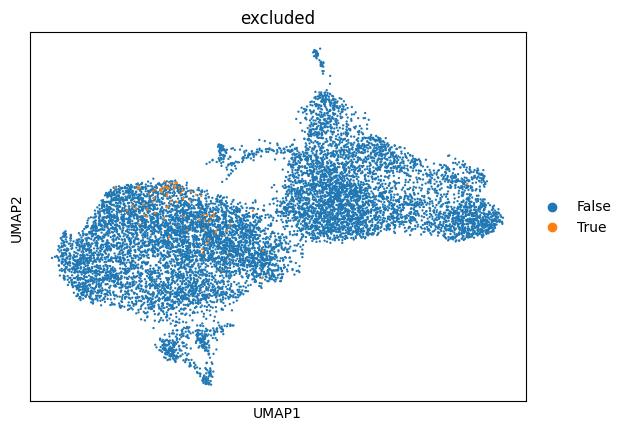

In [47]:
invalid_filter = radius_filter
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['log_lib_size_cellbender_noExcluded'] < 6)
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['percent_mito'] > 0.3)
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['log_detected_cellbender_noExcluded'] < np.log(300))

adata_sub.obs['excluded'] = pd.Categorical(invalid_filter)
sc.pl.umap(adata_sub, color='excluded')


In [48]:
adata_sub = adata_sub[np.logical_not(invalid_filter),:].copy()
adata_sub

AnnData object with n_obs × n_vars = 10772 × 16499
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded', 'n_counts', 'pheno', 'n_genes_by_counts', 'total_counts', 'excluded', 'D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_

# Filter Outlier based on Local outlier factor (radius threshold  = 0.2)

/tmp/ipykernel_4059/1264330931.py:29: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [10]
/tmp/ipykernel_4059/1264330931.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1]._sizes = [20]


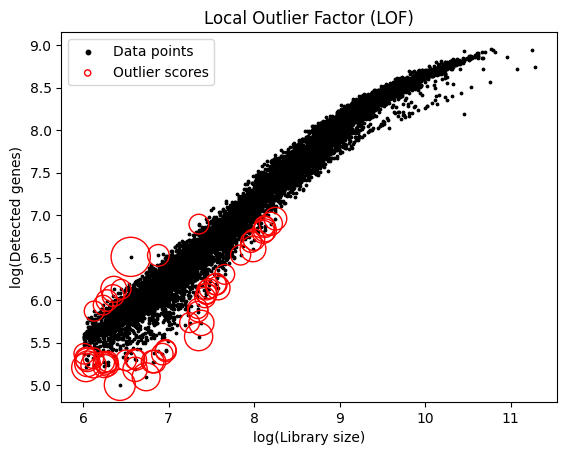

In [49]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=100, contamination=0.1)
X = np.array([[x,y] for x,y in zip(adata_sub.obs['log_lib_size_cellbender_noExcluded'], adata_sub.obs['log_detected_cellbender_all'])])
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")

# plot circles with radius proportional to the outlier scores

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

radius_threshold = 0.2

radius_filter = np.logical_and(radius > radius_threshold, adata_sub.obs['log_detected_cellbender_all'] < 7)

plt.scatter(
    X[radius_filter, 0],
    X[radius_filter, 1],
    s=1000 * radius[radius_filter],
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
#plt.scatter(X[adata.obs['unclear'] == 'True', 0], X[adata.obs['unclear'] == 'True', 1], s=3, color='blue')
plt.axis("tight")
legend = plt.legend(loc="upper left")
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.xlabel('log(Library size)')
plt.ylabel('log(Detected genes)')
plt.show()

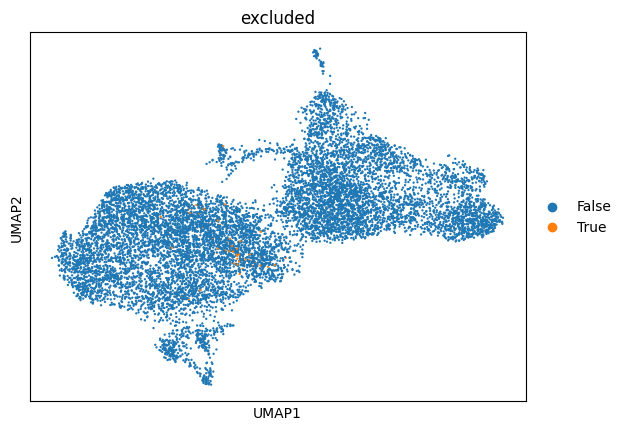

In [50]:
invalid_filter = radius_filter
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['log_lib_size_cellbender_noExcluded'] < 6)
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['percent_mito'] > 0.3)
invalid_filter = np.logical_or(invalid_filter, adata_sub.obs['log_detected_cellbender_noExcluded'] < np.log(300))

adata_sub.obs['excluded'] = pd.Categorical(invalid_filter)
sc.pl.umap(adata_sub, color='excluded')


In [51]:
import numpy as np
np.log(300)

5.703782474656201

In [52]:
sum(pd.Categorical(invalid_filter))

56

In [53]:
adata_sub = adata_sub[np.logical_not(invalid_filter),:].copy()
adata_sub

AnnData object with n_obs × n_vars = 10716 × 16499
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded', 'n_counts', 'pheno', 'n_genes_by_counts', 'total_counts', 'excluded', 'D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_size_lognormal_std', 'empty_droplet_size_lognormal_loc', 'empty_droplet_size_lognormal_

# Demultiplexing with hashsolo

In [54]:
import scanpy.external as sce

sce.pp.hashsolo(adata_sub, ['D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2'], priors = [0.01, 0.95, 0.04])
print(adata_sub.obs.groupby('Classification').size())
adata_sub

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2
Classification
D30_CTRL_1    1591
D30_CTRL_2    1795
D30_PIMQ_1    1080
D30_PIMQ_2    1315
Doublet       2150
Negative        41
Y1_CTRL_1      593
Y1_CTRL_2      712
Y1_PIMQ_1      762
Y1_PIMQ_2      677
dtype: int64


AnnData object with n_obs × n_vars = 10716 × 16499
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded', 'n_counts', 'pheno', 'n_genes_by_counts', 'total_counts', 'excluded', 'D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_

In [55]:
adata_sub = adata_sub[ ~adata_sub.obs['Classification'].isin(['Doublet', 'Negative'])]
adata_sub

View of AnnData object with n_obs × n_vars = 8525 × 16499
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded', 'n_counts', 'pheno', 'n_genes_by_counts', 'total_counts', 'excluded', 'D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_ce

# Filter doublets

In [56]:
adata_sub2 = adata_sub.copy()
adata_sub2

AnnData object with n_obs × n_vars = 8525 × 16499
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_raw', 'n_cellbender', 'percent_mito', 'percent_ribo', 'log_lib_size_raw_all', 'log_lib_size_raw_noExcluded', 'log_detected_raw_all', 'log_detected_raw_noExcluded', 'log_lib_size_cellbender_all', 'log_lib_size_cellbender_noExcluded', 'log_detected_cellbender_all', 'log_detected_cellbender_noExcluded', 'n_counts', 'pheno', 'n_genes_by_counts', 'total_counts', 'excluded', 'D30_CTRL_1', 'D30_CTRL_2', 'D30_PIMQ_1', 'D30_PIMQ_2', 'Y1_CTRL_1', 'Y1_CTRL_2', 'Y1_PIMQ_1', 'Y1_PIMQ_2', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'ambient_expression', 'feature_type', 'genome', 'gene_id', 'cellbender_analyzed', 'n_raw', 'n_cellbender', 'excluded', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells_by_c

Normalizing data
Log transform with pseudocount 1


/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/scipy/sparse/_construct.py:148: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if len(diagonals) == 0 or isscalarlike(diagonals[0]):
/home/lufesu/miniconda3/envs/scrna2_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


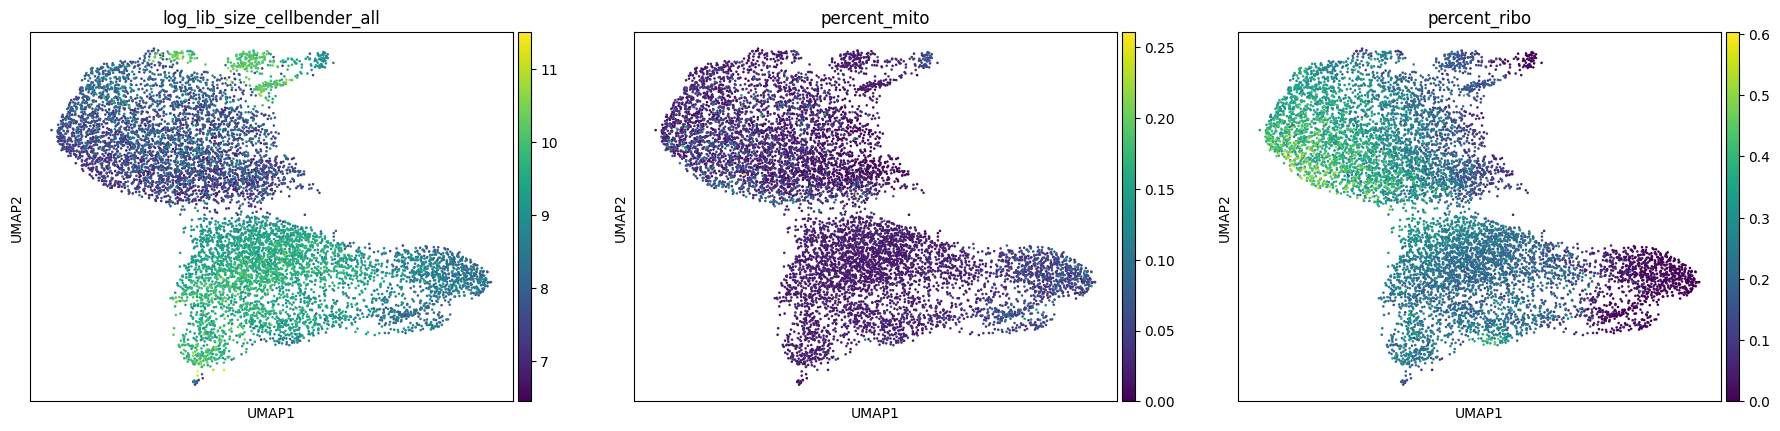

In [57]:
adata_sub.X = adata_sub.layers['cellbender'].copy()
adata_sub = norm_log_transform(adata_sub, np.exp(adata_sub.obs[size_factors]), [])
sc.pp.filter_cells(adata_sub, min_counts=1)
sc.pp.filter_genes(adata_sub, min_cells=10)
#adata_sub = lowess_HVG(adata_sub, n_bin=20, n_genes_per_bin=200, min_mean=0.001, exclude_genes=adata_sub.var['excluded'], plot_show=True)
sc.pp.highly_variable_genes(adata_sub, n_top_genes = 5000)
sc.pp.pca(adata_sub, n_comps=100, use_highly_variable=True)
sc.pp.neighbors(adata_sub, n_neighbors=31)
sc.tl.umap(adata_sub)
sc.pl.umap(adata_sub, color=[size_factors, 'percent_mito', 'percent_ribo'])


In [58]:
communities = sc.external.tl.phenograph(adata_sub, k=30, clustering_algo = 'leiden', seed = 0, copy=True)
adata_sub.obs['pheno'] = pd.Categorical(communities[0])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.20381712913513184 seconds
Jaccard graph constructed in 1.5084490776062012 seconds
Running Leiden optimization
Leiden completed in 1.0440125465393066 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.695276975631714 seconds


  0%|          | 0/10 [00:00<?, ?it/s]

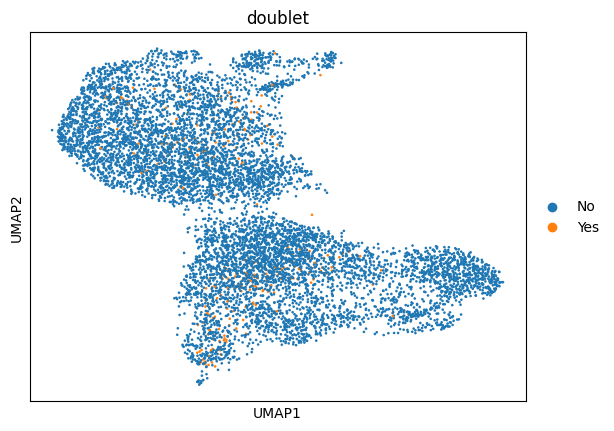

In [59]:
import doubletdetection
clf = doubletdetection.BoostClassifier(n_iters = 10)
labels = clf.fit(adata_sub.layers['raw']).predict()
scores = clf.doublet_score()
adata_sub.obs['doublet'] = ['No' if x == 0 else 'Yes' for x in labels]
sc.pl.umap(adata_sub, color=['doublet'])

In [60]:
import phenograph
phenograph.__version__

'1.5.7'

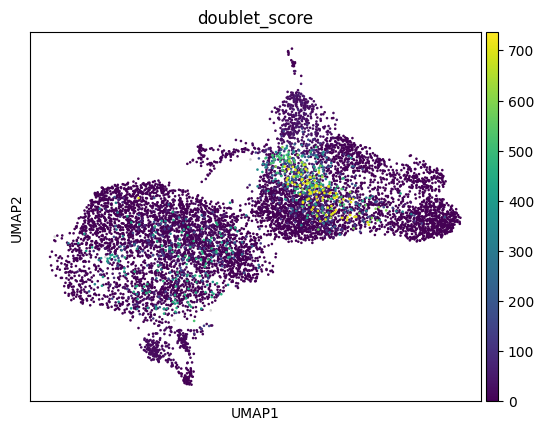

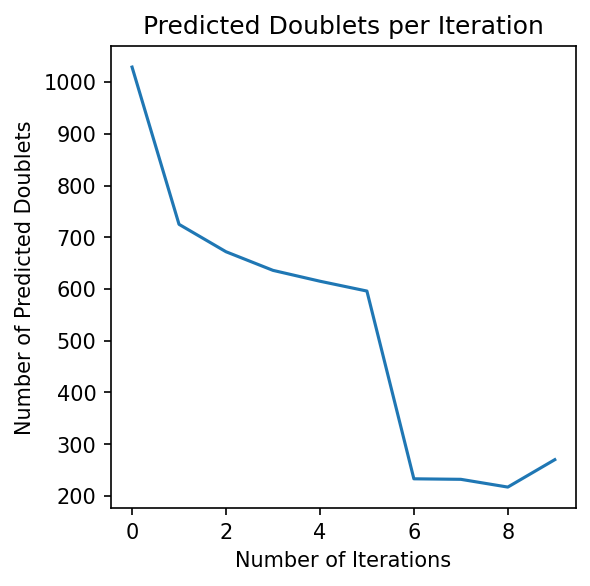

In [61]:
doublet_score = clf.doublet_score()
adata_sub2.obs['doublet_score'] = doublet_score 
sc.pl.umap(adata_sub2, color=['doublet_score'])
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf',show = True)


In [62]:
adata_sub.obs['excluded'] = pd.Categorical(adata_sub.obs['doublet']=='Yes')
adata_sub = adata_sub[adata_sub.obs['excluded'] == False,:].copy()

# Re-embed samples

Normalizing data
Log transform with pseudocount 1


/home/lufesu/miniconda3/envs/scrna_env/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


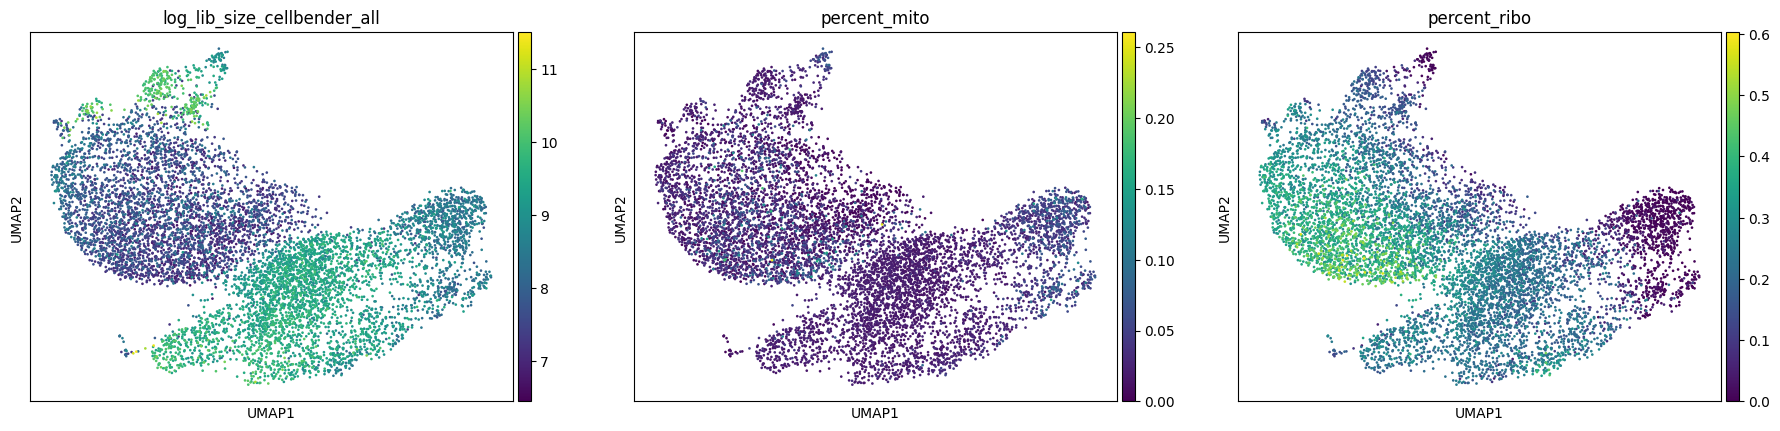

In [36]:
adata_sub.X = adata_sub.layers['cellbender'].copy()
adata_sub = norm_log_transform(adata_sub, np.exp(adata_sub.obs[size_factors]), [])
sc.pp.filter_cells(adata_sub, min_counts=1)
sc.pp.filter_genes(adata_sub, min_cells=10)
#adata_sub = lowess_HVG(adata_sub, n_bin=20, n_genes_per_bin=200, min_mean=0.001, exclude_genes=adata_sub.var['excluded'], plot_show=True)
sc.pp.highly_variable_genes(adata_sub)
sc.pp.pca(adata_sub, n_comps=100, use_highly_variable=True)
sc.pp.neighbors(adata_sub, n_neighbors=31)
sc.tl.umap(adata_sub)
sc.pl.umap(adata_sub, color=[size_factors, 'percent_mito', 'percent_ribo'])


In [37]:
np.sum(adata_sub.var['highly_variable'])

2896

In [38]:
communities = sc.external.tl.phenograph(adata_sub, k=30, clustering_algo = 'leiden', seed = 0, copy=True)
adata_sub.obs['pheno'] = pd.Categorical(communities[0])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.44765710830688477 seconds
Jaccard graph constructed in 0.7708680629730225 seconds
Running Leiden optimization
Leiden completed in 1.4219410419464111 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 3.295166015625 seconds


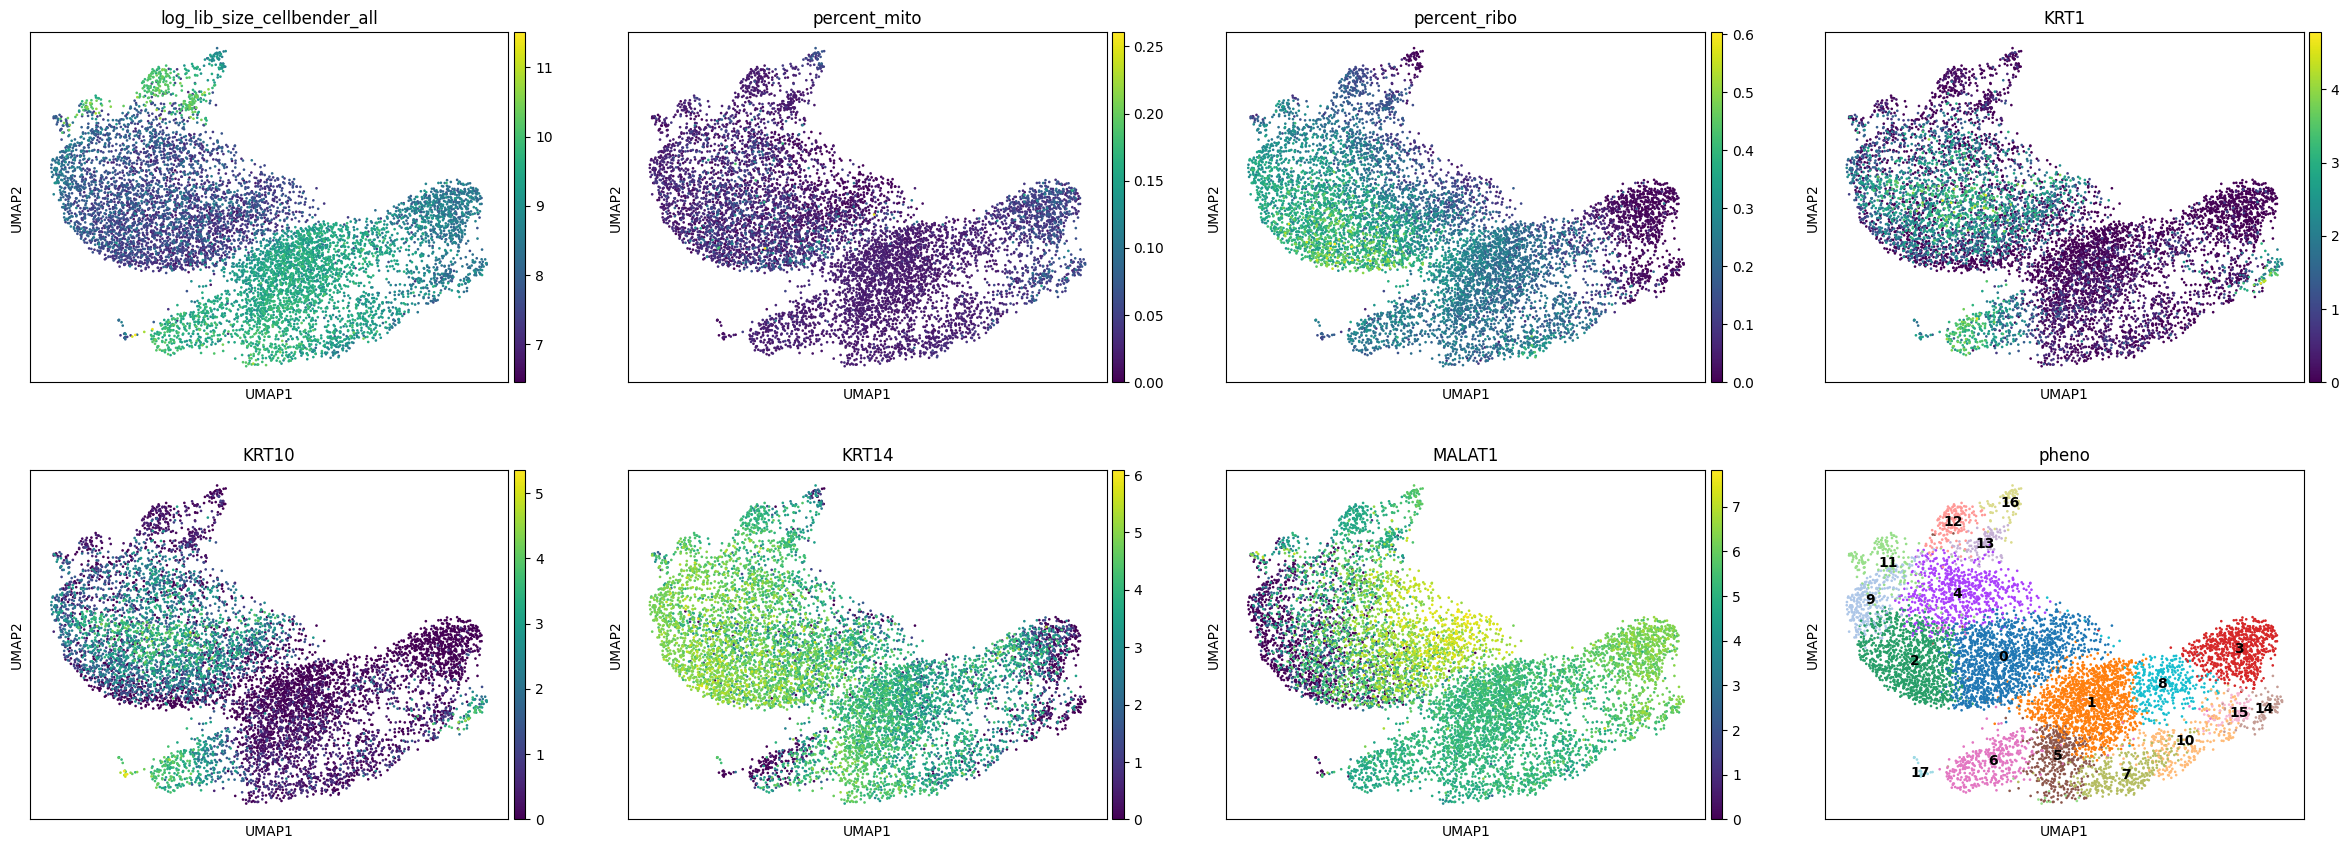

In [39]:
sc.pl.umap(adata_sub, color=['log_lib_size_cellbender_all', 'percent_mito', 'percent_ribo', 'KRT1', 'KRT10', 'KRT14', 'MALAT1', 'pheno'], legend_loc  =  'on data', frameon  = True) 

In [40]:
import pickle

pickle.dump(adata_sub, open("../intermediate_outputs/sc_data/epdsc_filtered_data.pickle",'wb'))